In [1]:
!pip install aicsimageio[nd2]
!pip install nd2reader

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 612.8 kB/s eta 0:00:0036m0:00:01m eta 0:00:01
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 KB 67.1 kB/s eta 0:00:00MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pims: filename=PIMS-0.7-py3-none-any.whl size=84607 sha256=cfefddc8e9a87267762d83142540cdfd9e123334a37fc3d50319837425ed43fc
  Stored in directory: /config/.cache/pip/wheels/54/cb/f1/939f4adc0c5bcb1a1a78566d67869368d3d8dc8abd84f63c38
Successfully built pims


In [1]:
# Check OpenCV version
import cv2
cv2.__version__

'4.5.4'

In [2]:
# Import required libraries
from pathlib import Path
import napari
from napari.settings import get_settings
import pandas as pd
import os
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from scipy import ndimage as ndi
from scipy.ndimage import label #, find_objects
from skimage.segmentation import relabel_sequential
from itertools import combinations
from skimage import filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from vispy.color import Colormap
from matplotlib.colors import to_rgb
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from collections import defaultdict
from aicsimageio import AICSImage
from nd2reader import ND2Reader
from scipy.ndimage import zoom
import meshlib.mrmeshpy as mr
import meshlib.mrmeshnumpy as mrn
from IPython.display import clear_output
from scipy.ndimage import binary_dilation, generate_binary_structure
import meshio
import statistics as st
import tetgen
from skimage.morphology import ball
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola

# Enable interactive mode for napari in Jupyter
settings = get_settings()
settings.application.ipy_interactive = True

2025-10-15 14:39:23.762182: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-15 14:39:23.769253: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-15 14:39:23.842077: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 14:39:25.194895: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Functions

In [3]:
# Image processing and utility functions

def gamma_trans(im_in, gamma):
    """Apply gamma correction to an image."""
    val_c = 255.0 / (np.max(im_in)**gamma)
    return (val_c * (im_in**gamma)).copy()

def contr_limit(im_in, c_min=None, c_max=None):
    """
    Stretch the contrast of the input image to the 0–255 range.
    
    Parameters:
    - im_in: Input image (NumPy array).
    - c_min: Minimum intensity to map to 0. If None, uses im_in.min().
    - c_max: Maximum intensity to map to 255. If None, uses im_in.max().
    
    Returns:
    - Contrast-stretched image (uint8).
    """
    im_in = im_in.astype(float)
    
    if c_min is None:
        c_min = im_in.min()
    if c_max is None:
        c_max = im_in.max()
    
    if c_max == c_min:
        return np.zeros_like(im_in, dtype=np.uint8)  # avoid division by zero

    alpha = 255.0 / (c_max - c_min)
    beta = -c_min * alpha

    im_out = alpha * im_in + beta
    return np.clip(im_out, 0, 255).astype(np.uint8)

def contr_stretch(im_in, c_min=None, c_max=None):
    """
    Mimic Fiji's Brightness/Contrast adjustment.
    Values below min_input become 0.
    Values above max_input become 255.
    Values in between are linearly scaled to 0–255.
    
    Parameters:
    - im_in: Input image (NumPy array).
    - min_input: Input value to be mapped to 0.
    - max_input: Input value to be mapped to 255.
    
    Returns:
    - Adjusted image (uint8).
    """
    im_in = im_in.astype(float)

    if c_min is None:
        c_min = im_in.min()
    if c_max is None:
        c_max = im_in.max()
    
    if c_max == c_min:
        return np.zeros_like(im_in, dtype=np.uint8)  # avoid division by zero

    # Normalize: subtract min and divide by (max - min)
    norm = (im_in - c_min) / (c_max - c_min)
    
    # Clip to [0, 1] so values outside range are fixed to 0 or 1
    norm = np.clip(norm, 0, 1)
    
    return (norm * 255).astype(np.uint8)

def hist_plot(im_in, stain_complete_df, thresh=0):
    """Plot histogram and CDF for each channel."""
    fig, axs = plt.subplots(1, im_in.shape[3], figsize=(15, 2))
    for c in range(im_in.shape[3]):
        hist, _ = np.histogram(im_in[:, :, :, c].flatten(), 256, [0, 256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max() / cdf.max()
        color = stain_complete_df.loc[stain_complete_df.index[c], 'Color']
        axs[c].plot(cdf_normalized, color='b')
        axs[c].hist(im_in[:, :, :, c].flatten(), 256, [0, 256], color=color if color != 'WHITE' else 'GRAY')
        axs[c].set_xlim([0, 256])
        axs[c].legend(('cdf', 'histogram'), loc='upper left')
        if thresh > 0:
            axs[c].plot([thresh, thresh], [0, cdf_normalized.max()], color='g')
        axs[c].set_title(stain_complete_df.index[c])
        axs[c].set_yscale('log')

def truncate_cell(val, width=15):
    """Truncate long values for display in tables."""
    val_str = str(val)
    return val_str if len(val_str) <= width else val_str[:width-3] + "..."

def merge_touching_labels(label_matrix):
    """Merge touching labels in a 3D label matrix using union-find."""
    if label_matrix.max() == 0:
        return label_matrix.copy()

    padded = np.pad(label_matrix, 1, mode='constant', constant_values=0)
    touching = defaultdict(set)

    # Iterate over the inner volume (excluding padding)
    for z in range(1, padded.shape[0] - 1):
        for y in range(1, padded.shape[1] - 1):
            for x in range(1, padded.shape[2] - 1):
                center = padded[z, y, x]
                if center == 0:
                    continue
                neighborhood = padded[z-1:z+2, y-1:y+2, x-1:x+2].ravel()
                for neighbor in neighborhood:
                    if neighbor != center and neighbor != 0:
                        touching[center].add(neighbor)

    # Union-Find to merge touching labels
    all_labels = set(np.unique(label_matrix)) - {0}
    parent = {label: label for label in all_labels}

    def find(u):
        while parent[u] != u:
            parent[u] = parent[parent[u]]
            u = parent[u]
        return u

    def union(u, v):
        pu, pv = find(u), find(v)
        if pu != pv:
            parent[pu] = pv

    for u, neighbors in touching.items():
        for v in neighbors:
            if u in parent and v in parent:
                union(u, v)

    label_map = {label: find(label) for label in all_labels}

    # Apply merged labels
    merged = np.zeros_like(label_matrix, dtype=np.int32)
    for label, root in label_map.items():
        merged[label_matrix == label] = root

    # Re-label to get sequential labels starting from 1
    merged, _, _ = relabel_sequential(merged)
    return merged

def remove_small_islands(binary_matrix, area_threshold):
    """Remove small connected components from a binary mask."""
    labeled_array, num_features = label(binary_matrix)
    for i in range(1, num_features + 1):
        component = (labeled_array == i)
        if component.sum() < area_threshold:
            binary_matrix[component] = 0
    return binary_matrix

def assign_labels(A, B, connectivity=1):
    """Assign labels from B to islands in A based on overlap (3D)."""
    if connectivity == 2:
        structure = np.ones((3, 3, 3))  # 26-connectivity
    else:
        structure = None  # default is 6-connectivity for 3D

    labeled_A, num_features = label(A, structure=structure)
    C = np.zeros_like(A, dtype=B.dtype)

    for i in range(1, num_features + 1):
        mask = labeled_A == i
        overlapping_labels = np.unique(B[mask & (B > 0)])
        C[mask] = overlapping_labels[0] if len(overlapping_labels) > 0 else 0

    return C

def grow_labels(label_matrix,volume_factor=5.0):
    structure = ball(3.0) #generate_binary_structure(3, 1)  # 6-connectivity in 3D
    output = label_matrix.copy()
    
    labels = np.unique(label_matrix)
    labels = labels[labels != 0]  # exclude background

    # Compute original volumes
    volumes = {label: np.sum(label_matrix == label) for label in labels}
    target_volumes = {label: volume_factor * vol for label, vol in volumes.items()}

    # Create masks for each label
    label_masks = {label: (label_matrix == label) for label in labels}
    grown_masks = label_masks.copy()

    # Initialize growing flags
    growing = {label: True for label in labels}

    # Start growing iterations
    while any(growing.values()):
        new_masks = {}
        occupied = np.zeros_like(label_matrix, dtype=bool)

        # Prepare current occupied space
        for label, mask in grown_masks.items():
            occupied |= mask

        for label in labels:
            if not growing[label]:
                continue
            # Grow
            dilated = binary_dilation(grown_masks[label], structure)
            # Only grow into free space
            new_mask = dilated & ~occupied
            combined = grown_masks[label] | new_mask
            if np.sum(combined) >= target_volumes[label]:
                growing[label] = False
            grown_masks[label] = combined
            new_masks[label] = combined

        # Update output matrix
        output[:] = 0
        for label, mask in grown_masks.items():
            output[mask] = label

    return output

## File upload

In [24]:
# Load TIFF file and extract image data
input_file = 'M2_ST_BX15048_10x.nd2'
meta = AICSImage(input_file)
img = meta.get_image_data("XYZ", T=0) 
print(img.shape)

(2400, 2400, 49)


In [25]:
# Get physical pixel sizes
r_X = meta.physical_pixel_sizes.X
r_Y = meta.physical_pixel_sizes.Y
r_Z = meta.physical_pixel_sizes.Z
print([r_X, r_Y, r_Z])

imdata=meta.get_image_data()
imtype=imdata.dtype
bdepth=imtype.itemsize*8
print(imtype)

[0.665431713778854, 0.665431713778854, 2.5]
uint16


In [26]:
nuclei_diameter=10 #um
cell_diameter=30 #um
nuclei_size=np.ceil(nuclei_diameter/np.mean([r_X,r_Y]))
cell_size=np.ceil(cell_diameter/np.mean([r_X,r_Y]))

In [27]:
with ND2Reader(input_file) as nd2:
    print("Date:", nd2.metadata.get("date"))
    print("Channels:", nd2.metadata.get("channels"))

Date: 2025-09-30 18:38:24
Channels: ['488_10x', 'DAPI_10x', '568_10x', '647_10x']


In [28]:
im_in = meta.get_image_data("ZYXC", S=0, T=0).astype('float32')
im_in = im_in[:,:,780:1340,:]

### Information about the staining

In [29]:
# Define staining dictionary and create DataFrame
stain_dict = {
    'NUCLEI': ['DAPI', 'DAPI_10x', 'Blue'],
    'MACRO': ['F4/80', '488_10x', 'Green'],
    'M1': ['CD80', '568_10x', 'Red'],
    'M2': ['CD206', '647_10x', 'White']
}

stain_dict = {k.upper(): [item.upper() if isinstance(item, str) else item for item in v] for k, v in stain_dict.items()}
stain_df = pd.DataFrame.from_dict(stain_dict, orient='index', columns=['Marker', 'Laser', 'Color'])
laser_order=nd2.metadata.get("channels")

# Map fluorophore to its order index
order_map = {name.strip().upper(): i for i, name in enumerate(laser_order)}
stain_df['order'] = stain_df['Laser'].map(order_map)

# Sort by that and drop helper column
stain_df = stain_df.sort_values('order').drop(columns='order')

stain_df.index.name = 'Condition'

if 'NUCLEI' not in stain_df.index:
    print('No nuclei condition!')

In [30]:
# Visualize each channel using napari
viewer_0 = napari.Viewer()
for c, c_name in enumerate(stain_df['Marker']):
    #im_in = meta.get_image_data("ZYX", C=c, S=0, T=0).astype('float32')
    im_channel = im_in[:,:,:,c]

    # Stretch to [0, 255]
    im_8b = ((im_channel - im_channel.min()) / (im_channel.max() - im_channel.min()) * 255).clip(0, 255).astype('uint8')
    
    viewer_0.add_image(im_8b, name=f"{stain_df.index[c]} ({c_name})", 
                        colormap=stain_df['Color'][c], blending='additive')

### Acquisition processing setup

In [33]:
# Setup for acquisition and contrast/gamma settings
name_setup = 'PRO_EB-012'
use_setup = False

stain_df = stain_df.reset_index(drop=False)
stain_initial_df = stain_df.copy()
stain_initial_df.set_index(['Condition', 'Marker', 'Laser'], inplace=True)
stain_initial_df[['Cont_min', 'Cont_max', 'Gamma']] = [0, 255, 1]
stain_complete_df=stain_initial_df.copy()

setup_path = f"{name_setup}_setup.csv"
if use_setup and os.path.exists(setup_path):
    stain_setup_df = pd.read_csv(setup_path)
    stain_setup_df.set_index(['Condition', 'Marker', 'Laser'], inplace=True)
    for idx in stain_complete_df.index:
        if idx in stain_setup_df.index:
            stain_complete_df.loc[idx] = stain_setup_df.loc[idx]
            stain_complete_df['Color'] = stain_initial_df['Color']
        else:
            use_setup = False

if not use_setup or not os.path.exists(setup_path):
    stain_complete_df=stain_initial_df.copy()
    settings.application.ipy_interactive = False
    viewer_1 = napari.Viewer()
    for c, idx in enumerate(stain_complete_df.index):
        im_channel = im_in[:,:,:,c]
        im_channel = ((im_channel - im_channel.min()) / (im_channel.max() - im_channel.min()) * 255).clip(0, 255).astype('uint8')
        viewer_1.add_image(im_channel, name=f"{idx[0]} ({idx[1]})", colormap=stain_initial_df.loc[idx]['Color'], blending='additive')
    napari.run()
    image_layers = [layer for layer in viewer_1.layers if isinstance(layer, napari.layers.Image)]
    contrast_limits = {layer.name: layer.contrast_limits for layer in image_layers}
    gamma_val = {layer.name: layer.gamma for layer in image_layers}
    stain_complete_df.sort_index(inplace=True)
    for c, idx in enumerate(stain_complete_df.index):
        name = f"{idx[0]} ({idx[1]})"
        stain_complete_df.loc[idx, 'Cont_min'] = int(contrast_limits[name][0])
        stain_complete_df.loc[idx, 'Cont_max'] = int(contrast_limits[name][1])
        stain_complete_df.loc[idx, 'Gamma'] = gamma_val[name]
    if os.path.exists(setup_path):
        stain_setup_df = pd.read_csv(setup_path)
        stain_setup_df.set_index(['Condition', 'Marker', 'Laser'], inplace=True)
        for idx in stain_complete_df.index:
            stain_setup_df.loc[idx] = stain_complete_df.loc[idx]
    else:
        stain_setup_df = stain_complete_df.copy()
    stain_csv_setup_df = stain_setup_df.reset_index().sort_values(by='Condition')
    stain_csv_setup_df = stain_csv_setup_df[['Condition', 'Marker', 'Laser', 'Cont_min', 'Cont_max', 'Gamma']]
    stain_csv_setup_df.to_csv(setup_path, index=False)

stain_df = stain_df.set_index('Condition')
stain_complete_df = stain_complete_df.reset_index().set_index('Condition')
stain_complete_df = stain_complete_df.loc[stain_df.index]
stain_complete_df = stain_complete_df[['Marker', 'Laser', 'Color', 'Cont_min', 'Cont_max', 'Gamma']]

In [34]:
# Display stain settings DataFrame
stain_complete_df

,Marker,Laser,Color,Cont_min,Cont_max,Gamma
Condition,,,,,,
MACRO,F4/80,488_10X,GREEN,13,156,0.486154
NUCLEI,DAPI,DAPI_10X,BLUE,18,129,0.846154
M1,CD80,568_10X,RED,23,206,0.698462
M2,CD206,647_10X,WHITE,9,196,0.901538


## IMAGE PROCESSING

In [35]:
# Adapt resolution to isotropic
scale_factor=1.0
#zoom_factors = [1.0, r_Y/r_Z, r_X/r_Z]  # ZYX order
zoom_factors = [1.0, 1.0, 1.0] 
zoom_factors = [x * scale_factor for x in zoom_factors]
print(zoom_factors)

im_out = np.zeros((round(np.shape(im_in)[0] * (zoom_factors[0])),round(np.shape(im_in)[1] * (zoom_factors[1])),round(np.shape(im_in)[2] * (zoom_factors[2])),np.shape(im_in)[3]))

# Compute zoom factors to get isotropic spacing (same as Y and X)

# Resample image to isotropic spacing
for c in range(im_in.shape[3]):
    im_out[:, :, :, c] = zoom(im_in[:, :, :, c], zoom=zoom_factors, order=1)

[1.0, 1.0, 1.0]


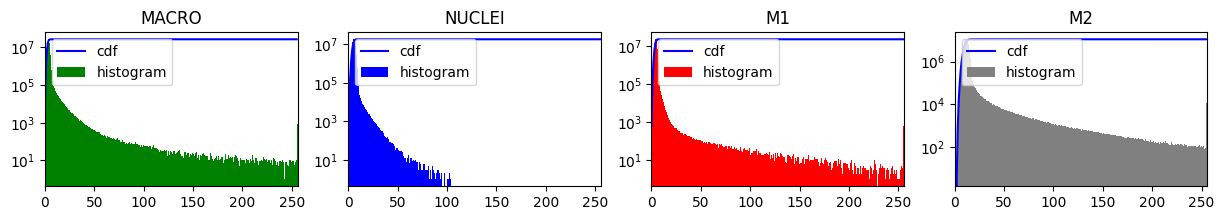

In [36]:
# Load and normalize image data for all channels
#im_in = meta.get_image_data("ZYXC", S=0, T=0)
im_in=im_out.copy()
im_in = ((im_in - im_in.min()) / (im_in.max() - im_in.min()) * 255).clip(0, 255).astype('uint8')
im_original = im_in.copy()
im_out = im_original.copy()
im_trans = im_out.copy()

# Plot histogram for each channel
hist_plot(im_out, stain_complete_df)

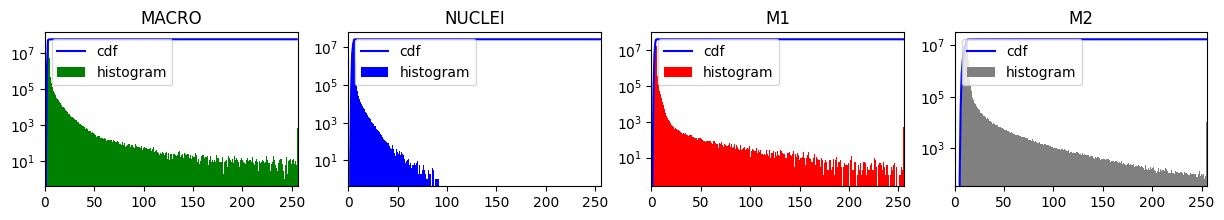

In [37]:
# Noise removal using median filter
im_in = im_out.copy()
for c in range(im_in.shape[3]):
    im_out[:, :, :, c] = filters.median(im_in[:, :, :, c])
im_denoised = im_out.copy()
hist_plot(im_out, stain_complete_df)

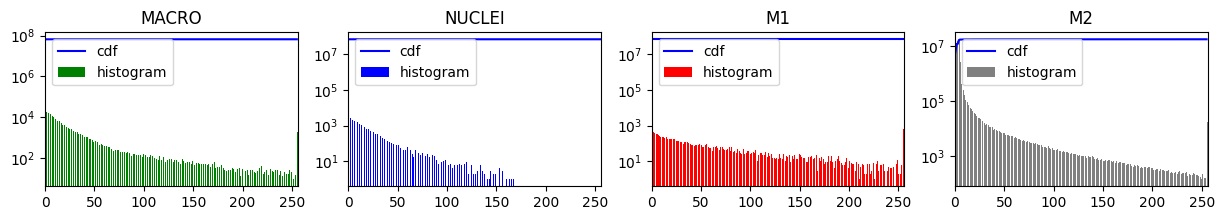

In [38]:
# Contrast and gamma adjustment for each channel
im_in = im_out.copy()
for c, idx in enumerate(stain_complete_df.index):
    im_out[:, :, :, c] = gamma_trans(im_in[:, :, :, c], stain_complete_df.loc[idx, 'Gamma'])
    im_out[:, :, :, c] = contr_stretch(im_in[:, :, :, c], stain_complete_df.loc[idx, 'Cont_min'], stain_complete_df.loc[idx, 'Cont_max'])
im_trans = im_out.copy()
hist_plot(im_out, stain_complete_df)

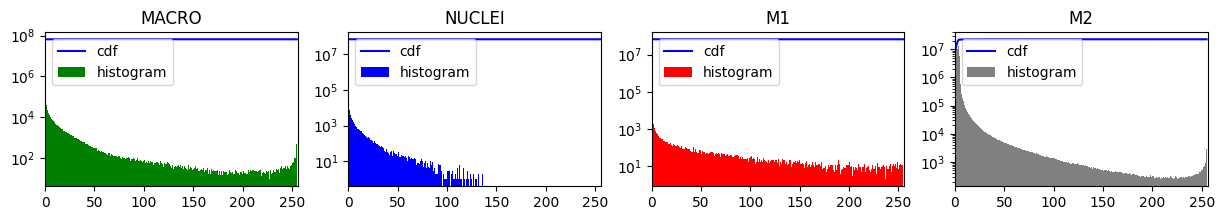

In [39]:
# Gaussian filter for smoothing
im_in = im_out.copy()
for c in range(im_in.shape[3]):
    im_out[:, :, :, c] = filters.gaussian(im_in[:, :, :, c], 1.0, preserve_range=True)
im_filtered = im_out.copy()
hist_plot(im_out, stain_complete_df)

In [40]:
# Thresholding using Otsu's method and small island removal
im_in = im_out.copy()
for c in range(im_in.shape[3]):
    img = sitk.GetImageFromArray(im_in[:, :, :, c])
    rescaler = sitk.RescaleIntensityImageFilter() 
    rescaler.SetOutputMinimum(0) 
    rescaler.SetOutputMaximum(255) 
    stretched = rescaler.Execute(img)
    
    th_filter = sitk.OtsuThresholdImageFilter()
    seg = th_filter.Execute(stretched)
    otsu_value = th_filter.GetThreshold() 
    print(otsu_value) 
    
    window_size=35 
    sauvola_value = threshold_sauvola(sitk.GetArrayFromImage(stretched), window_size=window_size)
    
    arrayseg = im_in[:, :, :, c] > np.ceil(0.2*sauvola_value+0.8*otsu_value) 
    im_out[:, :, :, c] = remove_small_islands(arrayseg, np.ceil(0.8*nuclei_size)) 
    
im_threshold = im_out.copy()

75.0
31.0
67.0
59.0


In [41]:
# # Thresholding using Otsu's method and small island removal
# im_in = im_out.copy()
# for c in range(im_in.shape[3]):
#     th_filter = sitk.OtsuThresholdImageFilter()
#     th_filter.SetInsideValue(0)
#     th_filter.SetOutsideValue(200)
#     seg = th_filter.Execute(sitk.GetImageFromArray(im_in[:, :, :, c]))
#     arrayseg = sitk.GetArrayFromImage(seg)
#     #filtered = remove_small_islands(arrayseg, 30)
#     im_out[:, :, :, c] = arrayseg
# im_threshold = im_out.copy()

In [42]:
# Segmentation of nuclei using watershed or StarDist
if 'NUCLEI' in stain_df.index:
    im_in = im_out.copy()
    im_out = np.zeros_like(im_in, dtype=np.int32)
    trig_stardist = False  # Set to True to use StarDist model
    
    for c in range(im_in.shape[3]):
        if stain_complete_df.index[c] == 'NUCLEI':
            if trig_stardist:
                model = StarDist2D.from_pretrained('3D_versatile_fluo')
                img_te = normalize(im_filtered[:, :, :, c], 1.0, 99.8)
                im_out[:, :, :, c], _ = model.predict_instances(img_te)
                im_mask = im_in[:, :, :, c] / np.max(im_in[:, :, :, c])
                im_mask = filters.binary_erosion(im_mask, footprint=np.ones((2, 2, 2))).astype(im_mask.dtype)
                im_positive = im_out[:, :, :, c] * im_mask
            else:
                distance = ndi.distance_transform_edt(im_in[:, :, :, c],sampling=[r_Z,r_Y,r_X])
                coords = peak_local_max(distance, footprint=np.ones((3, 3, 3)), labels=im_in[:, :, :, c].astype(np.int32))
                mask = np.zeros(distance.shape, dtype=bool)
                mask[tuple(coords.T)] = True
                markers, _ = label(mask)
                transl = watershed(-distance, markers, mask=im_in[:, :, :, c])
                im_out[:, :, :, c] = merge_touching_labels(transl)
            
            cm_rand = np.random.rand(int(np.max(im_out[:, :, :, c])), 3)
            cm_rand[0, :] = [0.0, 0.0, 0.0]
            colormaps_rand = Colormap(cm_rand)
            im_nuclei_segmented = im_out[:, :, :, c].copy()

In [43]:
# Segmentation of cytoplasm
if ('NUCLEI' in stain_df.index)|('CYTOPLASM' in stain_df.index):
    im_out = np.zeros_like(im_in[:,:,:,0], dtype=np.int32)
    trig_stardist = False  # Set to True to use StarDist model
    im_final=im_in.copy()
    
    for c in range(im_in.shape[3]):
        if stain_complete_df.index[c] == 'CYTOPLASM':
            distance = ndi.distance_transform_edt(im_final[:, :, :, c],sampling=[r_Z,r_Y,r_X])
            coords = peak_local_max(distance, footprint=ball(5), labels=im_final[:, :, :, c].astype(bool))
            mask = np.zeros(distance.shape, dtype=bool)
            mask[tuple(coords.T)] = True
            markers, _ = label(mask)
            transl = watershed(-distance, im_nuclei_segmented, mask=im_final[:, :, :, c])
            im_out = transl
    
    if 'CYTOPLASM' not in stain_df.index:
        cyto_factor=5.0
        im_out=grow_labels(im_nuclei_segmented, cyto_factor)
        im_final = np.concatenate((im_in, np.expand_dims(im_out, axis=-1)), axis=-1)
        stain_df.loc['CYTOPLASM']=['', '', '']
        stain_complete_df.loc['CYTOPLASM']=['', '', '', '', '', '']
        
    im_cyto_segmented = im_out.copy()

In [44]:
# Assign segmented nuclei labels to other channels (cell assignment)
if ('NUCLEI' in stain_df.index)|('CYTOPLASM' in stain_df.index):
    im_assigned = np.zeros_like(im_final, dtype=np.int32)
    for c in range(im_final.shape[3]):
        if (stain_df.index[c] != 'NUCLEI') & (stain_df.index[c] != 'CYTOPLASM'):
            im_assigned[:, :, :, c] = im_threshold[:, :, :, c] * im_cyto_segmented/200

In [45]:
# Visualize original, denoised, filtered, corrected, thresholded, assigned, and segmented images
viewer_0 = napari.Viewer()

for c in range(im_in.shape[3]):
    idx = stain_complete_df.index[c]
    marker = stain_complete_df.loc[idx, 'Marker']
    color = stain_complete_df['Color'].iloc[c]
    viewer_0.add_image(im_original[:, :, :, c], name=f'ORIGINAL {idx} ({marker})', colormap=color, blending='additive')
    viewer_0.add_image(im_denoised[:, :, :, c], name=f'DENOISED {idx} ({marker})', colormap=color, blending='additive')
    viewer_0.add_image(im_filtered[:, :, :, c], name=f'FILTERED {idx} ({marker})', colormap=color, blending='additive')
    viewer_0.add_image(im_trans[:, :, :, c], name=f'CORRECTED {idx} ({marker})', colormap=color, blending='additive')
    viewer_0.add_image(im_threshold[:, :, :, c].astype('uint8'), name=f'THRESHOLD {idx} ({marker})', colormap=color, blending='additive')    
viewer_0.scale_bar.visible = True
viewer_0.scale_bar.unit = 'um'

if ('NUCLEI' in stain_df.index)|('CYTOPLASM' in stain_df.index):
    viewer_1 = napari.Viewer()
    
    for c in range(im_final.shape[3]):
        idx = stain_complete_df.index[c]
        marker = stain_complete_df.loc[idx, 'Marker']
        if stain_df.index[c] == 'NUCLEI':
            viewer_1.add_image(im_nuclei_segmented.astype('uint8'), name=f'SEGMENTED {idx} ({marker})', colormap=colormaps_rand, contrast_limits=[0, np.max(im_nuclei_segmented)], blending='additive')
        if stain_df.index[c] == 'CYTOPLASM':
            viewer_1.add_image(im_cyto_segmented.astype('uint8'), name=f'{idx} ({marker})', colormap=colormaps_rand, contrast_limits=[0, np.max(im_nuclei_segmented)], blending='additive')
        if (stain_df.index[c] != 'NUCLEI') & (stain_df.index[c] != 'CYTOPLASM'):
            viewer_1.add_image(im_assigned[:, :, :, c].astype('uint8'), name=f'ASSIGNED {idx} ({marker})', colormap=colormaps_rand, contrast_limits=[0, np.max(im_nuclei_segmented)], blending='additive')
    viewer_1.scale_bar.visible = True
    viewer_1.scale_bar.unit = 'um'

## QUANTIFICATION

In [26]:
multilabel=True

# Quantify nuclei and cell properties
im_mask = im_nuclei_segmented > 0
labels_dict = {}
c_nuc = stain_complete_df.index.get_loc('NUCLEI')
nuc_marker = stain_complete_df['Marker'][c_nuc]
nuc_positions = []
nuc_sizes=[]
c_cyto = stain_complete_df.index.get_loc('CYTOPLASM')
cyto_marker = stain_complete_df['Marker'][c_cyto]
cyto_positions = []
cyto_sizes=[]

for n in range(1, int(np.max(im_nuclei_segmented))):
    zN, yN, xN = np.where(im_nuclei_segmented == n)
    nuc_positions.append((np.mean(xN * r_X / zoom_factors[2]), np.mean(yN * r_Y / zoom_factors[1]), np.mean(zN * r_Z / zoom_factors[0])))
    nuc_sizes.append(xN.size * r_X * r_Y * r_Z / np.prod(zoom_factors))
    zC, yC, xC = np.where(im_cyto_segmented == n)
    cyto_positions.append((np.mean(xC * r_X / zoom_factors[2]), np.mean(yC * r_Y / zoom_factors[1]), np.mean(zC * r_Z / zoom_factors[0])))
    cyto_sizes.append(xC.size * r_X * r_Y * r_Z / np.prod(zoom_factors))

labels_dict[stain_complete_df['Marker'].iloc[c_nuc]] = [
    stain_complete_df.index[c_nuc],
    stain_complete_df['Laser'][c_nuc],
    stain_complete_df['Color'][c_nuc],
    int(np.max(im_nuclei_segmented)),
    (),
    tuple(nuc_positions),
    (), 
    tuple(nuc_sizes), 
    (), 
    ()
]
labels_dict[stain_complete_df['Marker'].iloc[c_cyto]] = [
    stain_complete_df.index[c_cyto],
    stain_complete_df['Laser'][c_cyto],
    stain_complete_df['Color'][c_cyto],
    int(np.max(im_cyto_segmented)),
    (),
    (),
    tuple(cyto_positions),
    (),
    tuple(cyto_sizes),
    ()
]

for c in range(im_original.shape[3]):
    if (c != c_nuc)&(c != c_cyto):
        m_nuc_positions = []
        m_nuc_sizes=[]
        marker_sizes=[]
        m_cyto_positions = []
        m_cyto_sizes=[]
        marker = stain_complete_df['Marker'][c]
        for n in np.unique(im_assigned[1:, :, :, c])[1:]:
            zN, yN, xN = np.where(im_nuclei_segmented == n)
            m_nuc_positions.append((np.mean(xN * r_X / zoom_factors[2]), np.mean(yN * r_Y / zoom_factors[1]), np.mean(zN * r_Z / zoom_factors[0])))
            m_nuc_sizes.append(xN.size * r_X * r_Y * r_Z / np.prod(zoom_factors))

            zC, yC, xC = np.where(im_cyto_segmented == n)
            m_cyto_positions.append((np.mean(xC * r_X / zoom_factors[2]), np.mean(yC * r_Y / zoom_factors[1]), np.mean(zC * r_Z / zoom_factors[0])))
            m_cyto_sizes.append(xC.size * r_X * r_Y * r_Z / np.prod(zoom_factors))
            
            zM, yM, xM = np.where(im_assigned[:,:,:,c] == n)
            marker_sizes.append(xM.size * r_X * r_Y * r_Z / np.prod(zoom_factors))
            
        labels_dict[stain_complete_df['Marker'].iloc[c]] = [
            stain_complete_df.index[c],
            stain_complete_df['Laser'][c],
            stain_complete_df['Color'][c],
            len(np.unique(im_assigned[1:, :, :, c])[1:]),
            tuple(np.unique(im_assigned[1:, :, :, c])[1:]),
            tuple(m_nuc_positions),
            tuple(m_cyto_positions), 
            tuple(m_nuc_sizes), 
            tuple(m_cyto_sizes), 
            tuple(marker_sizes)
        ]

if multilabel:
    # All combinations of channels (2 or more)
    layers_n = list(range(im_final.shape[3]))
    layers_n.remove(c_nuc)
    layers_n.remove(c_cyto)
    all_combinations = []
    for k in range(2, len(layers_n) + 1):
        all_combinations.extend(combinations(layers_n, k))
    
    for comb in all_combinations:
        combo_labels=list(np.unique(im_assigned[1:, :, :, comb[0]])[1:])
        for c in comb[1:]:
            list2_set = set(list(np.unique(im_assigned[1:, :, :, c])[1:]))
            combo_labels = [x for x in combo_labels if x in list2_set]

        combo_marker=[stain_complete_df['Marker'].iloc[idx] for idx in comb]
        combo_condition=[stain_complete_df.index[idx] for idx in comb]

        labels_dict[tuple(combo_marker)] = [
            tuple(combo_condition),
            (),
            (),
            len(combo_labels),
            tuple(combo_labels),
            tuple(nuc_positions[i-1] for i in combo_labels),
            tuple(cyto_positions[i-1] for i in combo_labels),
            tuple(nuc_sizes[i-1] for i in combo_labels),
            tuple(cyto_sizes[i-1] for i in combo_labels),
            ()
        ]

In [27]:
# Create DataFrame for quantification results and truncate long values for display
labels_df = pd.DataFrame.from_dict(labels_dict, orient='index', columns=['Condition', 'Laser', 'Color', 'Number', 'Shared labels', 'Mean nuclei positions [um]', 'Mean cytoplasm positions [um]', 'Nuclei size [um3]', 'Cytoplasm size [um3]', 'Marker size [um3]'])
labels_df.index.name = 'Combination'
truncated_df = labels_df.copy()
for col in ["Shared labels", "Mean nuclei positions [um]", "Mean cytoplasm positions [um]", "Nuclei size [um3]", "Cytoplasm size [um3]", "Marker size [um3]"]:
    truncated_df[col] = truncated_df[col].apply(lambda x: truncate_cell(x))

In [28]:
# Display quantification DataFrame
labels_df

,Condition,Laser,Color,Number,Shared labels,Mean nuclei positions [um],Mean cytoplasm positions [um],Nuclei size [um3],Cytoplasm size [um3],Marker size [um3]
Combination,,,,,,,,,,
DAPI,NUCLEI,DAPI_10X,BLUE,24,(),"((9.346290888984813, 1154.3501037538467, 16.13...",(),"(97.41586045458578, 114.02083666843565, 57.563...",(),()
,CYTOPLASM,,,24,(),(),"((9.342995836059805, 1154.3651004690826, 16.13...",(),"(792.6108646077662, 849.0677837348557, 623.240...",()
F4/80,MACRO,488_10X,GREEN,1,"(18,)","((201.70258985735188, 1020.6698748269499, 56.0...","((201.75078059684878, 1020.6294245689265, 56.0...","(28.781958770673075,)","(453.8693498452293,)","(145.01679226762204,)"
CD80,M1,568_10X,RED,0,(),(),(),(),(),()
CD206,M2,647_10X,WHITE,13,"(1, 3, 4, 6, 9, 11, 12, 13, 15, 16, 18, 22, 23)","((9.346290888984813, 1154.3501037538467, 16.13...","((9.342995836059805, 1154.3651004690826, 16.13...","(97.41586045458578, 57.56391754134615, 18.8189...","(792.6108646077662, 623.2401072264977, 373.058...","(792.6108646077662, 383.0214513328033, 263.465..."
"(F4/80, CD80)","(MACRO, M1)",(),(),0,(),(),(),(),(),()
"(F4/80, CD206)","(MACRO, M2)",(),(),1,"(18,)","((201.70258985735188, 1020.6698748269499, 56.0...","((201.75078059684878, 1020.6294245689265, 56.0...","(28.781958770673075,)","(453.8693498452293,)",()
"(CD80, CD206)","(M1, M2)",(),(),0,(),(),(),(),(),()
"(F4/80, CD80, CD206)","(MACRO, M1, M2)",(),(),0,(),(),(),(),(),()


In [29]:
# Print summary statistics for nuclei and cell populations
print('TOT CELLS =', labels_df['Number'][stain_complete_df['Marker']['NUCLEI']])
print(" ")
for i, marker in enumerate(labels_df.index):
    if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (labels_df['Condition'][i] != 'NUCLEI + CYTOPLASM'):
        print(f" PERC {labels_df['Condition'][i]} ({marker}) = {100.0 * labels_df['Number'][i] / labels_df['Number'][0]} %")
print('_' * 80)
print('MEAN SIZE NUCLEI =', np.mean(labels_df['Nuclei size [um3]'][stain_complete_df['Marker']['NUCLEI']]), 'um3')
if 'CYTOPLASM' in stain_df.index:
    print('MEAN SIZE CYTOPLASM =', np.mean(labels_df['Cytoplasm size [um3]'][stain_complete_df['Marker']['CYTOPLASM']]), 'um3')
for i, marker in enumerate(labels_df.index):
    if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (labels_df['Condition'][i] != 'NUCLEI + CYTOPLASM'):
        print(" ")
        print(f" MEAN SIZE NUCLEI {labels_df['Condition'][i]} ({marker}) = {np.mean(labels_df['Nuclei size [um3]'][i])} um3")
        if 'CYTOPLASM' in stain_df.index:
            print(f" MEAN SIZE CYTOPLASM {labels_df['Condition'][i]} ({marker}) = {np.mean(labels_df['Cytoplasm size [um3]'][i])} um3")
print('_' * 80)
for i, marker in enumerate(labels_df.index):
    if (labels_df['Marker size [um3]'][i]!=()):
        print(f"MEAN SIZE {labels_df['Condition'][i]} ({marker}) = {np.mean(labels_df['Marker size [um3]'][i])} um3")

TOT CELLS = 24
 
 PERC MACRO (F4/80) = 4.166666666666667 %
 PERC M1 (CD80) = 0.0 %
 PERC M2 (CD206) = 54.166666666666664 %
 PERC ('MACRO', 'M1') (('F4/80', 'CD80')) = 0.0 %
 PERC ('MACRO', 'M2') (('F4/80', 'CD206')) = 4.166666666666667 %
 PERC ('M1', 'M2') (('CD80', 'CD206')) = 0.0 %
 PERC ('MACRO', 'M1', 'M2') (('F4/80', 'CD80', 'CD206')) = 0.0 %
________________________________________________________________________________
MEAN SIZE NUCLEI = 105.06858862270788 um3
MEAN SIZE CYTOPLASM = 1007.7054695344181 um3
 
 MEAN SIZE NUCLEI MACRO (F4/80) = 28.781958770673075 um3
 MEAN SIZE CYTOPLASM MACRO (F4/80) = 453.8693498452293 um3
 
 MEAN SIZE NUCLEI M1 (CD80) = nan um3
 MEAN SIZE CYTOPLASM M1 (CD80) = nan um3
 
 MEAN SIZE NUCLEI M2 (CD206) = 30.399879529971265 um3
 MEAN SIZE CYTOPLASM M2 (CD206) = 415.8907888638086 um3
 
 MEAN SIZE NUCLEI ('MACRO', 'M1') (('F4/80', 'CD80')) = nan um3
 MEAN SIZE CYTOPLASM ('MACRO', 'M1') (('F4/80', 'CD80')) = nan um3
 
 MEAN SIZE NUCLEI ('MACRO', 'M2') ((

fromnumeric.py (3504): Mean of empty slice.
_methods.py (129): invalid value encountered in scalar divide


## Evaluate cell distribution in the space

In [ ]:
# Plot spatial distribution of nuclei and cells
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
for i, marker in enumerate(labels_df.index):   
    xcoor = [t[0] for t in labels_df['Mean cytoplasm positions [um]'][i]]
    ycoor = [t[1] for t in labels_df['Mean cytoplasm positions [um]'][i]]
    zcoor = [t[2] for t in labels_df['Mean cytoplasm positions [um]'][i]] 
    xcount, xbins = np.histogram(xcoor, range=(0, im_original.shape[2] * r_X /zoom_factors[2]), bins=30)
    ycount, ybins = np.histogram(ycoor, range=(0, im_original.shape[1] * r_Y /zoom_factors[1]), bins=30)
    zcount, zbins = np.histogram(zcoor, range=(0, im_original.shape[0] * r_Z /zoom_factors[0]), bins=30)
    xbin_centers = (xbins[:-1] + xbins[1:]) / 2
    ybin_centers = (ybins[:-1] + ybins[1:]) / 2
    zbin_centers = (zbins[:-1] + zbins[1:]) / 2
    if (np.size(marker)==1):
        color = stain_df.loc[str(labels_df['Condition'][i])]['Color']
        if color == '':
            color='BLUE'
        if (labels_df['Condition'][i]!='NUCLEI'):
            axs[0].plot(xbin_centers,xcount,label=str(labels_df['Condition'][i]),color=color)
            axs[1].plot(ybin_centers,ycount,label=str(labels_df['Condition'][i]),color=color)
            axs[2].plot(zbin_centers,zcount,label=str(labels_df['Condition'][i]),color=color)
    else:
        rgb_list=[]
        for k in range(np.size(marker)):
            if stain_df.loc[(labels_df['Condition'][i][k])]['Color']!='WHITE':
                rgb_list.append(stain_df.loc[(labels_df['Condition'][i][k])]['Color'])
            else:
                rgb_list.append('GRAY')

        colors_rgb = [to_rgb(name) for name in rgb_list]

        r_total, g_total, b_total = 0.0, 0.0, 0.0

        for r, g, b in colors_rgb:
            r_total += r
            g_total += g
            b_total += b
        
        r_final = min(r_total, 1.0)
        g_final = min(g_total, 1.0)
        b_final = min(b_total, 1.0)
    
        final_rgb = (r_final, g_final, b_final)
        
        axs[0].plot(xbin_centers,xcount,label=str(labels_df['Condition'][i]),linestyle=(0, (2, np.size(marker)-1)), color=final_rgb)
        axs[1].plot(ybin_centers,ycount,label=str(labels_df['Condition'][i]),linestyle=(0, (2, np.size(marker)-1)), color=final_rgb)
        axs[2].plot(zbin_centers,zcount,label=str(labels_df['Condition'][i]),linestyle=(0, (2, np.size(marker)-1)), color=final_rgb)
        
axs[0].set_title('NUCLEI X DISTRIBUTION')
axs[0].set_xlabel('[μm]')
axs[0].legend(loc='upper right')
axs[0].set_facecolor('black')
axs[1].set_title('NUCLEI Y DISTRIBUTION')
axs[1].set_xlabel('[μm]')
axs[1].legend(loc='upper right')
axs[1].set_facecolor('black')
axs[2].set_title('NUCLEI Z DISTRIBUTION')
axs[2].set_xlabel('[μm]')
axs[2].legend(loc='upper right')
axs[2].set_facecolor('black')

## Evaluate cell size distribution

In [ ]:
# Plot size distribution of nuclei and cells
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
nuclei_max_size = max(x for t in labels_df['Nuclei size [um3]'] for x in t)
cytoplasm_max_size = max(x for t in labels_df['Cytoplasm size [um3]'] for x in t)
for i, marker in enumerate(labels_df.index):
    nuclei_sizes = list(labels_df['Nuclei size [um3]'][i])
    cell_sizes = list(labels_df['Cytoplasm size [um3]'][i])
    if np.size(marker)==1:
        if stain_df.loc[(labels_df['Condition'][i])]['Color']=='':
            color = 'BLUE'
        else:
            if stain_df.loc[(labels_df['Condition'][i])]['Color']!='WHITE':
                color = stain_df.loc[str(labels_df['Condition'][i])]['Color']
            else:
                color = 'GRAY'
        #color = stain_df.loc[str(labels_df['Condition'][i])]['Color']
        #axs[0].hist(nuclei_sizes, range=(0, nuclei_max_size), bins=30, label=str(labels_df['Condition'][i]), alpha=1/len(labels_df), color=color)
    else:
        rgb_list=[]
        for k in range(np.size(marker)):
            if stain_df.loc[(labels_df['Condition'][i][k])]['Color']!='WHITE':
                rgb_list.append(stain_df.loc[(labels_df['Condition'][i][k])]['Color'])
            else:
                rgb_list.append('GRAY')

        colors_rgb = [to_rgb(name) for name in rgb_list]

        r_total, g_total, b_total = 0.0, 0.0, 0.0

        for r, g, b in colors_rgb:
            r_total += r
            g_total += g
            b_total += b
        
        r_final = min(r_total, 1.0)
        g_final = min(g_total, 1.0)
        b_final = min(b_total, 1.0)
    
        color = (r_final, g_final, b_final)
        
    if labels_df['Condition'][i] != 'CYTOPLASM':    
        axs[0].hist(nuclei_sizes, range=(0, nuclei_max_size), bins=30, label=str(labels_df['Condition'][i]), alpha=1/len(labels_df), color=color)
    if labels_df['Condition'][i] != 'NUCLEI':
        axs[1].hist(cell_sizes, range=(0, cytoplasm_max_size), bins=30, label=str(labels_df['Condition'][i]), alpha=1/(len(labels_df)-1), color=color)
axs[0].set_title('NUCLEI SIZE DISTRIBUTION')
axs[0].set_xlabel('[μm3]')
axs[0].legend(loc='upper right')
axs[1].set_title('CELL SIZE DISTRIBUTION')
axs[1].set_xlabel('[μm3]')
axs[1].legend(loc='upper right')

## CREATE .VTK VOLUME

In [ ]:
diamond = ndi.generate_binary_structure(rank=3, connectivity=1)
blocks_nuclei=pv.MultiBlock()
blocks_cyto=pv.MultiBlock()
nuclei_stl_old=mr.Mesh()
cyto_stl_old=mr.Mesh()

nuc_vol=np.zeros((np.max(im_nuclei_segmented)+1,))
nuc_coord=np.zeros((np.max(im_nuclei_segmented)+1,3))
nuc_list=np.zeros((np.max(im_nuclei_segmented)+1,))

cyto_vol=np.zeros((np.max(im_nuclei_segmented)+1,))
cyto_coord=np.zeros((np.max(im_nuclei_segmented)+1,3))
cyto_list=np.zeros((np.max(im_nuclei_segmented)+1,))

#agg_id=1

k=0
for j in range(1,np.max(im_nuclei_segmented)+1):
    clear_output(wait=True)
    print('NUCLEI ' + str(j) + ' / ' + str(np.max(im_nuclei_segmented)))
    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_nuclei_segmented==j))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)    
    mr.saveMesh(mesh_stl, "part_nuclei_mesh.stl" )
    
    mesh_nuclei = pv.read("part_nuclei_mesh.stl")
    if mesh_nuclei.volume>0.0:
        mesh_nuclei.decimate(target_reduction=0.8, inplace=True)

        nuc_vol[k]=mesh_nuclei.volume
        nuc_coord[k]=mesh_nuclei.center
        nuc_list[k]=j

        mesh_nuclei.cell_data['ID']=np.ones(mesh_nuclei.n_cells)*(k+1)
        mesh_nuclei.cell_data['nuclei_vol']=np.ones(mesh_nuclei.n_cells)*nuc_vol[k] * r_X * r_Y * r_Z / np.prod(zoom_factors)
        mesh_nuclei.cell_data['nuclei_Z']=np.ones(mesh_nuclei.n_cells)*nuc_coord[k][0] * r_Z /zoom_factors[0]
        mesh_nuclei.cell_data['nuclei_Y']=np.ones(mesh_nuclei.n_cells)*nuc_coord[k][1] * r_Y /zoom_factors[1]
        mesh_nuclei.cell_data['nuclei_X']=np.ones(mesh_nuclei.n_cells)*nuc_coord[k][2] * r_X /zoom_factors[2]
        
        blocks_nuclei.append(mesh_nuclei)
        k=k+1


    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_cyto_segmented==j))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)    
    mr.saveMesh(mesh_stl, "part_cyto_mesh.stl" )
    
    mesh_cyto = pv.read("part_cyto_mesh.stl")
    if mesh_cyto.volume>0.0:
        mesh_cyto.decimate(target_reduction=0.8, inplace=True)

        cyto_vol[k]=mesh_cyto.volume
        cyto_coord[k]=mesh_cyto.center
        cyto_list[k]=j

        mesh_cyto.cell_data['ID']=np.ones(mesh_cyto.n_cells)*(k+1)
        mesh_cyto.cell_data['cyto_vol']=np.ones(mesh_cyto.n_cells)*cyto_vol[k] * r_X * r_Y * r_Z / np.prod(zoom_factors)
        mesh_cyto.cell_data['cyto_Z']=np.ones(mesh_cyto.n_cells)*cyto_coord[k][0] * r_Z /zoom_factors[0]
        mesh_cyto.cell_data['cyto_Y']=np.ones(mesh_cyto.n_cells)*cyto_coord[k][1] * r_Y /zoom_factors[1]
        mesh_cyto.cell_data['cyto_X']=np.ones(mesh_cyto.n_cells)*cyto_coord[k][2] * r_X /zoom_factors[2]
        for i, marker in enumerate(labels_df.index):
            if (labels_df['Condition'][i]!='NUCLEI') & (labels_df['Condition'][i]!='CYTOPLASM') & (np.size(marker)==1):
                if j in list(labels_df['Shared labels'][i]):
                    mesh_cyto.cell_data[marker+'_abs']=np.ones(mesh_cyto.n_cells)*(labels_df['Marker size [um3]'][i][list(labels_df['Shared labels'][i]).index(j)])
                    mesh_cyto.cell_data[marker+'_rel']=np.ones(mesh_cyto.n_cells)*((labels_df['Marker size [um3]'][i][list(labels_df['Shared labels'][i]).index(j)])/(cyto_vol[k] * r_X * r_Y * r_Z / np.prod(zoom_factors)))
                else:
                    mesh_cyto.cell_data[marker+'_abs']=np.ones(mesh_cyto.n_cells)*(0.0)
                    mesh_cyto.cell_data[marker+'_rel']=np.ones(mesh_cyto.n_cells)*(0.0)
                # ass_channel_2=globals()[channel+'mag']*(NUCLEIlab==val)/np.max(globals()[channel+'mag'])
                # mesh_cyto.cell_data[channel+'_perc_rel']=np.ones(mesh_nuclei.n_cells)*(np.sum(ass_channel_2)/np.sum(NUCLEIlab==val))
        
        blocks_cyto.append(mesh_cyto)
        #k=k+1

    #j=j-1

# nuc_vol=nuc_vol[0:k-1]
# nuc_coord=nuc_coord[0:k-1]
# nuc_list=nuc_list[0:k-1]
blocks_nuclei.extract_geometry().save(Path(input_file).stem+'_NUCLEI_labelled.vtk')
blocks_cyto.extract_geometry().save(Path(input_file).stem+'_CYTOPLASM_labelled.vtk')

## and .STL for markers

In [ ]:
for c, marker in enumerate(stain_complete_df.index):
    if (stain_complete_df.index[c] != 'NUCLEI') & (stain_complete_df.index[c] != 'CYTOPLASM'):
        simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_assigned[:, :, :, c]>0))
        floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
        mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)    
        mr.saveMesh(mesh_stl,Path(input_file).stem + "_" + marker + "_mesh.stl" )

### Create a complete report XSL

In [ ]:
# Export quantification results to Excel file
with pd.ExcelWriter(Path(input_file).stem + '_nuclei_segmentation.xlsx', engine='xlsxwriter') as writer:
    stain_complete_df.to_excel(writer, sheet_name='Staining', index=True)
    xlsx_dict = {}
    columns = ['X position [um]', 'Y position [um]', 'Z position [um]', 'Nuclei size [um3]']
    for i, marker in enumerate(labels_df.index):
        if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (np.size(labels_df['Condition'][i])==1):
            columns.append(f"{marker} ({labels_df['Condition'][i]})")
            columns.append(f"{labels_df['Condition'][i]} marker size [um3]")
    for k in range(1, int(labels_df['Number'][0])):
        row = [labels_df['Mean nuclei positions [um]'][0][k-1], labels_df['Nuclei size [um3]'][0][k-1]]
        row = [row[0][0], row[0][1], row[0][2], row[1]]
        for i, marker in enumerate(labels_df.index):
            if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (np.size(labels_df['Condition'][i])==1):
                shared = labels_df['Shared labels'][i]
                if k in shared:
                    idx = list(shared).index(k)
                    row.append(marker)
                    row.append(labels_df['Marker size [um3]'][marker][idx])
                else:
                    row.extend(['', ''])
        xlsx_dict[k] = row
    cell_df = pd.DataFrame.from_dict(xlsx_dict, orient='index', columns=columns)
    cell_df.to_excel(writer, sheet_name='NUCLEI', index=True)  
    xlsx_dict = {}
    columns = ['X position [um]', 'Y position [um]', 'Z position [um]', 'Cytoplasm size [um3]']
    for i, marker in enumerate(labels_df.index):
        if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (np.size(labels_df['Condition'][i])==1):
            columns.append(f"{marker} ({labels_df['Condition'][i]})")
            columns.append(f"{labels_df['Condition'][i]} marker size [um3]")
    for k in range(1, int(labels_df['Number'][0])):
        row = [labels_df['Mean cytoplasm positions [um]'][1][k-1], labels_df['Cytoplasm size [um3]'][1][k-1]]
        row = [row[0][0], row[0][1], row[0][2], row[1]]
        for i, marker in enumerate(labels_df.index):
            if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (np.size(labels_df['Condition'][i])==1):
                shared = labels_df['Shared labels'][i]
                if k in shared:
                    idx = list(shared).index(k)
                    row.append(marker)
                    row.append(labels_df['Marker size [um3]'][marker][idx])
                else:
                    row.extend(['', ''])
        xlsx_dict[k] = row
    cell_df = pd.DataFrame.from_dict(xlsx_dict, orient='index', columns=columns)
    cell_df.to_excel(writer, sheet_name='CYTOPLASM', index=True)
    resume_df = labels_df.drop(columns=['Shared labels', 'Mean nuclei positions [um]', 'Mean cytoplasm positions [um]', 'Nuclei size [um3]', 'Cytoplasm size [um3]', 'Marker size [um3]'])
    resume_df['Laser'] = [
        labels_df['Laser'][t] if (np.size(labels_df['Condition'][t])==1) else ''
        for t in range(len(labels_df))
    ]
    resume_df['Color'] = [
        labels_df['Color'][t] if (np.size(labels_df['Condition'][t])==1) else ''
        for t in range(len(labels_df))
    ]
    resume_df['%'] = [
        100.0 * labels_df['Number'][t] / labels_df['Number'][0] if labels_df['Condition'][t] != 'NUCLEI' else ''
        for t in range(len(labels_df))
    ]
    resume_df['Mean nuclei size [um3]'] = [np.mean(t) for t in labels_df['Nuclei size [um3]']]
    resume_df['Mean cytoplasm size [um3]'] = [np.mean(t) for t in labels_df['Cytoplasm size [um3]']]
    resume_df['Mean marker size [um3]'] = [
        np.mean(val) if (labels_df['Condition'][t] != 'NUCLEI') & (labels_df['Condition'][t] != 'CYTOPLASM') & (np.size(labels_df['Condition'][t])==1) else ''
        for t, val in enumerate(labels_df['Marker size [um3]'])
    ]
    resume_df.to_excel(writer, sheet_name='RECAP', index=True)

# CREATE .inp FOR FINITE ELEMENT ANALYSIS

In [ ]:
simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_nuclei_segmented))
floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)

outVerts = mrn.getNumpyVerts(mesh_stl)
#print(outVerts)

outFaces = mrn.getNumpyFaces(mesh_stl.topology)

tet = tetgen.TetGen(outVerts,outFaces)
nodes,elems=tet.tetrahedralize(order=1, mindihedral=20, minratio=1.5)

tet.write('FE_segmentation_full.vtk', binary=False)

In [ ]:
meshel = meshio.read('FE_segmentation_full.vtk')
meshel.write('FE_segmentation.inp')

for c in range(1, np.max(im_nuclei_segmented)+1):
    globals()[str(c)+'cell_el']=[]

for ce, x in enumerate(elems):
    #print(np.shape(np.uint16(np.mean(nodes[x],0))))
    coord=np.int16(np.round(np.mean(nodes[x],0),0))
    step=0
    taken=False
    while not(taken):
        step+=1
        coord[coord<step]=1
        for k in [0,1,2]:
            if coord[k]>=np.shape(im_nuclei_segmented)[k]+1-step:coord[k]=np.shape(im_nuclei_segmented)[k]-1
        elemlist=im_nuclei_segmented[coord[0]-step:coord[0]+1+step,coord[1]-step:coord[1]+1+step,coord[2]-step:coord[2]+1+step].flatten()
        #print(elemlist)
        if sum(elemlist)>0:
            c_el=st.mode(elemlist[elemlist!=0])
            taken=True

    #print(c_el)
    if c_el!=0:
        globals()[str(c_el)+'cell_el'].append(ce+1)

f = open("FE_segmentation.inp", "a")
for c in range(1,np.max(im_nuclei_segmented)+1):
    f.write("*Elset, elset=cell" + str(c) + "\n")
    j=1
    for t in range(1, np.size(globals()[str(c)+'cell_el'])):
        f.write(str(globals()[str(c)+'cell_el'][t]) + ",")
        j+=1
        if j>16:
            f.write("\n")
            j=1
    f.write("\n")

    
f.close()

In [ ]:
# Now insert *PART header manually
with open("FE_segmentation.inp", "r") as f:
    lines = f.readlines()

with open(Path(input_file).stem + "_FEA.inp", "w") as f:
    for line in lines:
        if (line=="*NODE\n"):
            f.write("*PART, name=Part-1\n")
        f.write(line)
    f.write("*END PART\n")